In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys, os

import xarray as xr

import scipy
from scipy import signal
sys.path.append('C:/Users/alexp/como')

import warnings
import math
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
#from tigramite.independence_tests import GPDC, CMIknn, CMIsymb
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Prediction

import networkx as nx

# Load the data

In [20]:
# Load data
t2m_balkans_3daymean=xr.open_mfdataset('C:/Users/alexp/como/t2m_balkans_3daymean.nc').var167
t2m_balkans_5daymean=xr.open_mfdataset('C:/Users/alexp/como/t2m_balkans_5daymean.nc').var167
t2m_balkans_7daymean=xr.open_mfdataset('C:/Users/alexp/como/t2m_balkans_7daymean.nc').var167

sm_balkans_3daymean=xr.open_mfdataset('C:/Users/alexp/como/sm_balkans_3daymean.nc').var39
sm_balkans_5daymean=xr.open_mfdataset('C:/Users/alexp/como/sm_balkans_5daymean.nc').var39
sm_balkans_7daymean=xr.open_mfdataset('C:/Users/alexp/como/sm_balkans_7daymean.nc').var39



In [21]:
# take a look at the data
sm_balkans_3daymean

<xarray.DataArray 'var39' (time: 5235, lat: 10, lon: 8)>
dask.array<open_dataset-var39, shape=(5235, 10, 8), dtype=float32, chunksize=(5235, 10, 8), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 ...
  * lat      (lat) float64 46.0 45.0 44.0 43.0 42.0 41.0 40.0 39.0 38.0 37.0
  * lon      (lon) float64 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-04 ... 2023-12-29
Attributes:
    cell_methods:  time: mean

In [22]:
sm_balkans_7daymean


<xarray.DataArray 'var39' (time: 2244, lat: 10, lon: 8)>
dask.array<open_dataset-var39, shape=(2244, 10, 8), dtype=float32, chunksize=(2244, 10, 8), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 ...
  * lat      (lat) float64 46.0 45.0 44.0 43.0 42.0 41.0 40.0 39.0 38.0 37.0
  * lon      (lon) float64 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-08 ... 2023-12-28
Attributes:
    cell_methods:  time: mean

In [23]:
# Calculate the spatial average 
t2m_balkans_3daymean_avg = t2m_balkans_3daymean.mean(dim=["lat", "lon"])
t2m_balkans_5daymean_avg = t2m_balkans_5daymean.mean(dim=["lat", "lon"])
t2m_balkans_7daymean_avg = t2m_balkans_7daymean.mean(dim=["lat", "lon"])

sm_balkans_3daymean_avg = sm_balkans_3daymean.mean(dim=["lat", "lon"])
sm_balkans_5daymean_avg = sm_balkans_5daymean.mean(dim=["lat", "lon"])
sm_balkans_7daymean_avg = sm_balkans_7daymean.mean(dim=["lat", "lon"])


In [25]:
# Setting the number of years and time cycle according to our data
n_years = 43
time_cycle_7day = 52  # 52 weeks in a year
time_cycle_5day = 73  # 73 5-days in a year
time_cycle_3day = 122  # 122 3-days in a year

# 7-day window

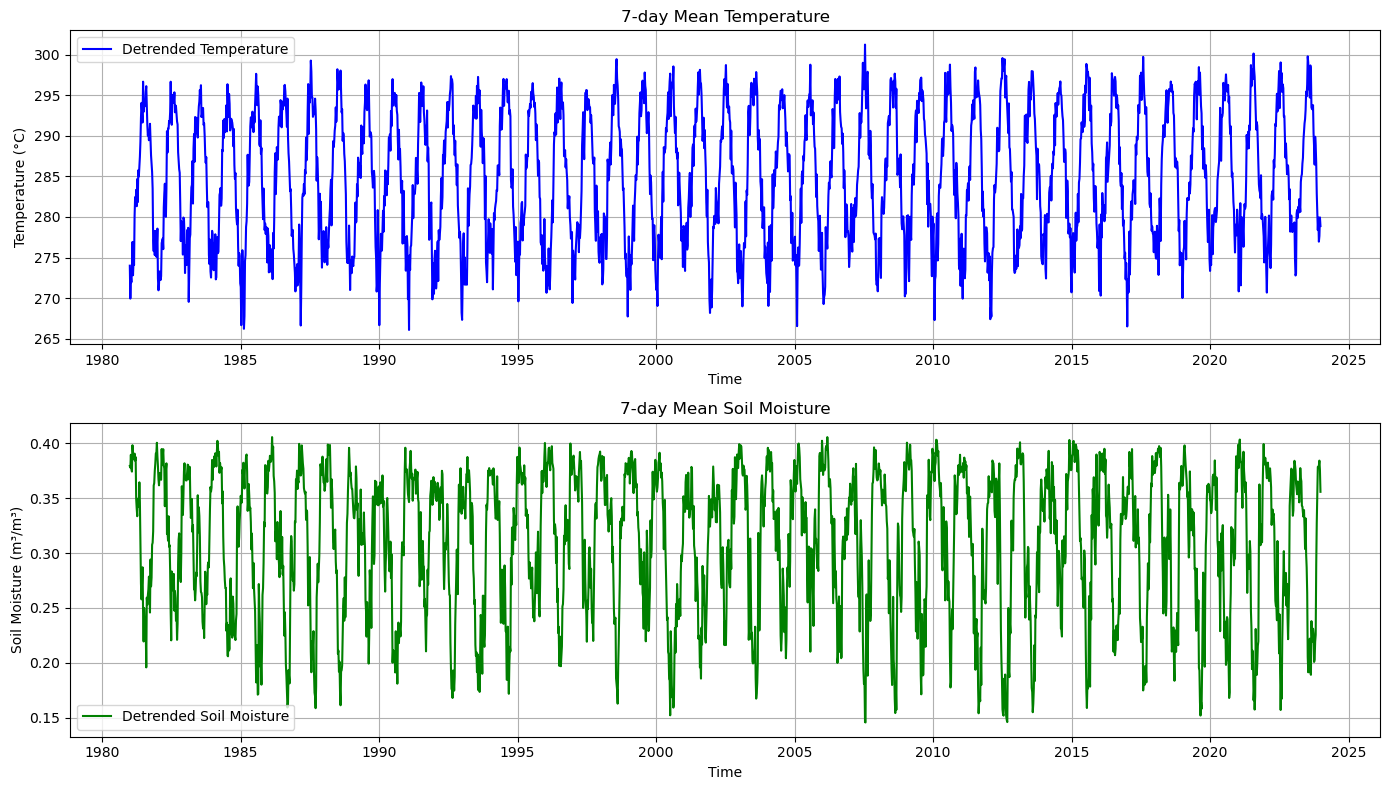

In [24]:
# Plotting the time series
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_7daymean_avg.time, t2m_balkans_7daymean_avg, label='Detrended Temperature', color='blue')
plt.title('7-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_7daymean_avg.time, sm_balkans_7daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('7-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Detrend the data for 7-days
for j in range(time_cycle_7day):
    t2m_balkans_7daymean_avg[j::time_cycle_7day] = signal.detrend(t2m_balkans_7daymean_avg[j::time_cycle_7day], axis=0)
    sm_balkans_7daymean_avg[j::time_cycle_7day] = signal.detrend(sm_balkans_7daymean_avg[j::time_cycle_7day], axis=0)


#    NAO[j::time_cycle] = signal.detrend(NAO[j::time_cycle], axis=0)
#    AO[j::time_cycle] = signal.detrend(AO[j::time_cycle], axis=0)
#    MOI[j::time_cycle] = signal.detrend(MOI[j::time_cycle], axis=0)
#    RMM_MJO[j::time_cycle] = signal.detrend(RMM_MJO[j::time_cycle], axis=0)
#    PNA[j::time_cycle] = signal.detrend(PNA[j::time_cycle], axis=0)

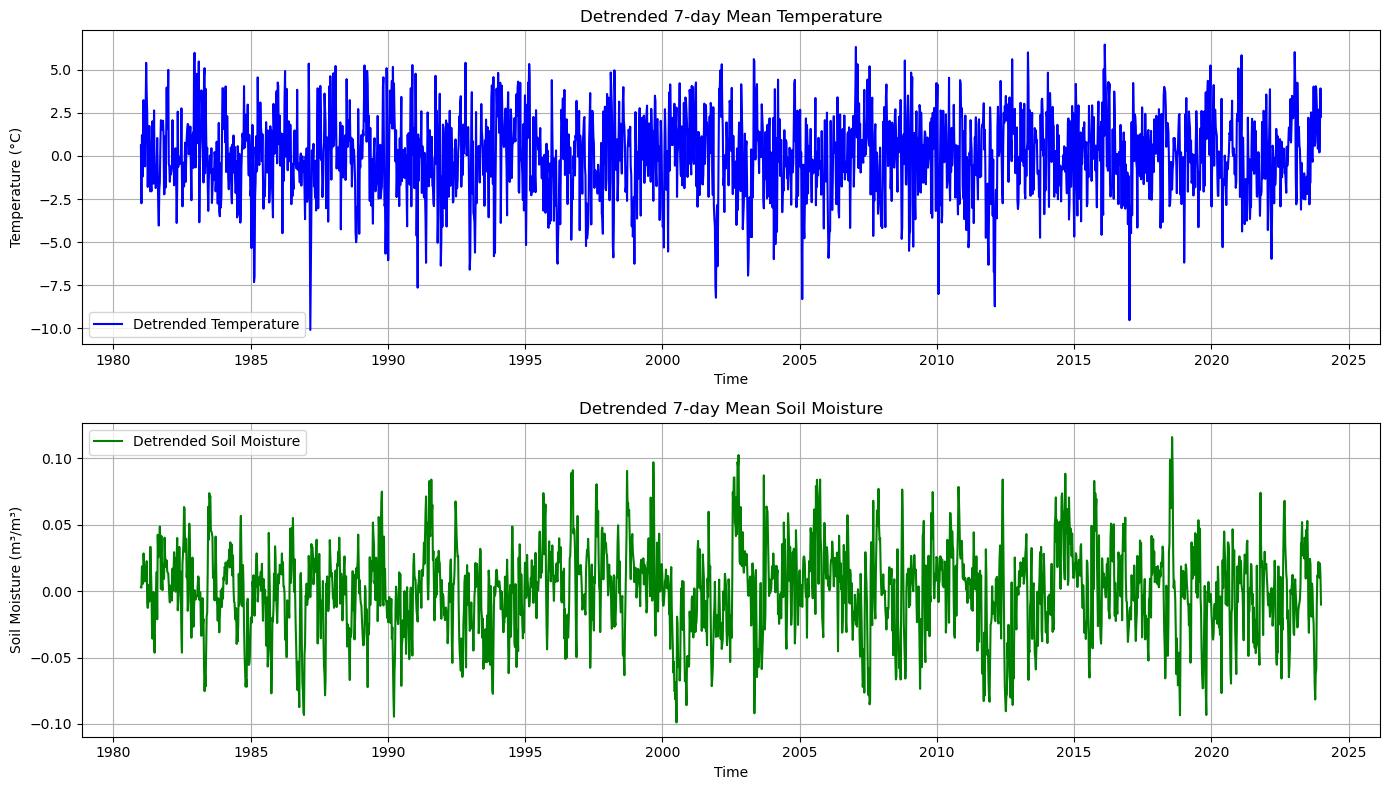

In [27]:
# Plotting the detrended time series
plt.figure(figsize=(14, 8))

# Plot Detrended Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_7daymean_avg.time, t2m_balkans_7daymean_avg, label='Detrended Temperature', color='blue')
plt.title('Detrended 7-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Detrended Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_7daymean_avg.time, sm_balkans_7daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('Detrended 7-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Calculate anomalies for 7-days
for i in range(time_cycle_7day):
    t2m_balkans_7daymean_avg[i::time_cycle_7day] = (t2m_balkans_7daymean_avg[i::time_cycle_7day] - np.mean(t2m_balkans_7daymean_avg[:int(time_cycle_7day*n_years)][i::time_cycle_7day], axis=0))
    sm_balkans_7daymean_avg[i::time_cycle_7day] = (sm_balkans_7daymean_avg[i::time_cycle_7day] - np.mean(sm_balkans_7daymean_avg[:int(time_cycle_7day*n_years)][i::time_cycle_7day], axis=0))


#    NAO[i::time_cycle] = (NAO[i::time_cycle] - np.mean(NAO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    AO[i::time_cycle] = (AO[i::time_cycle] - np.mean(AO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    MOI[i::time_cycle] = (MOI[i::time_cycle] - np.mean(MOI[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    RMM_MJO[i::time_cycle] = (RMM_MJO[i::time_cycle] - np.mean(RMM_MJO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    PNA[i::time_cycle] = (PNA[i::time_cycle] - np.mean(PNA[:int(time_cycle*n_years)][i::time_cycle], axis=0))

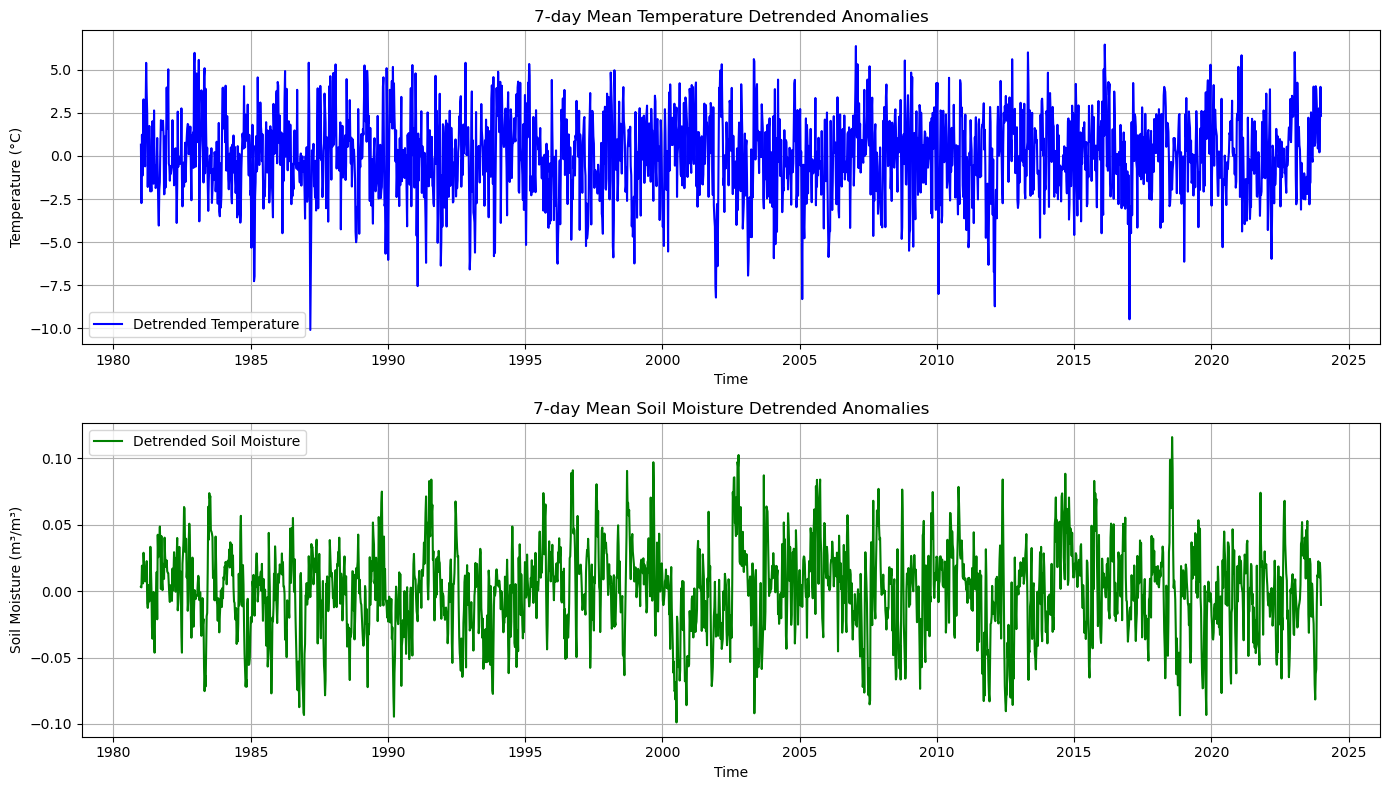

In [29]:
# Plotting the detrended time series
plt.figure(figsize=(14, 8))

# Plot Detrended Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_7daymean_avg.time, t2m_balkans_7daymean_avg, label='Detrended Temperature', color='blue')
plt.title('7-day Mean Temperature Detrended Anomalies')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Detrended Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_7daymean_avg.time, sm_balkans_7daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('7-day Mean Soil Moisture Detrended Anomalies')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5-Day window

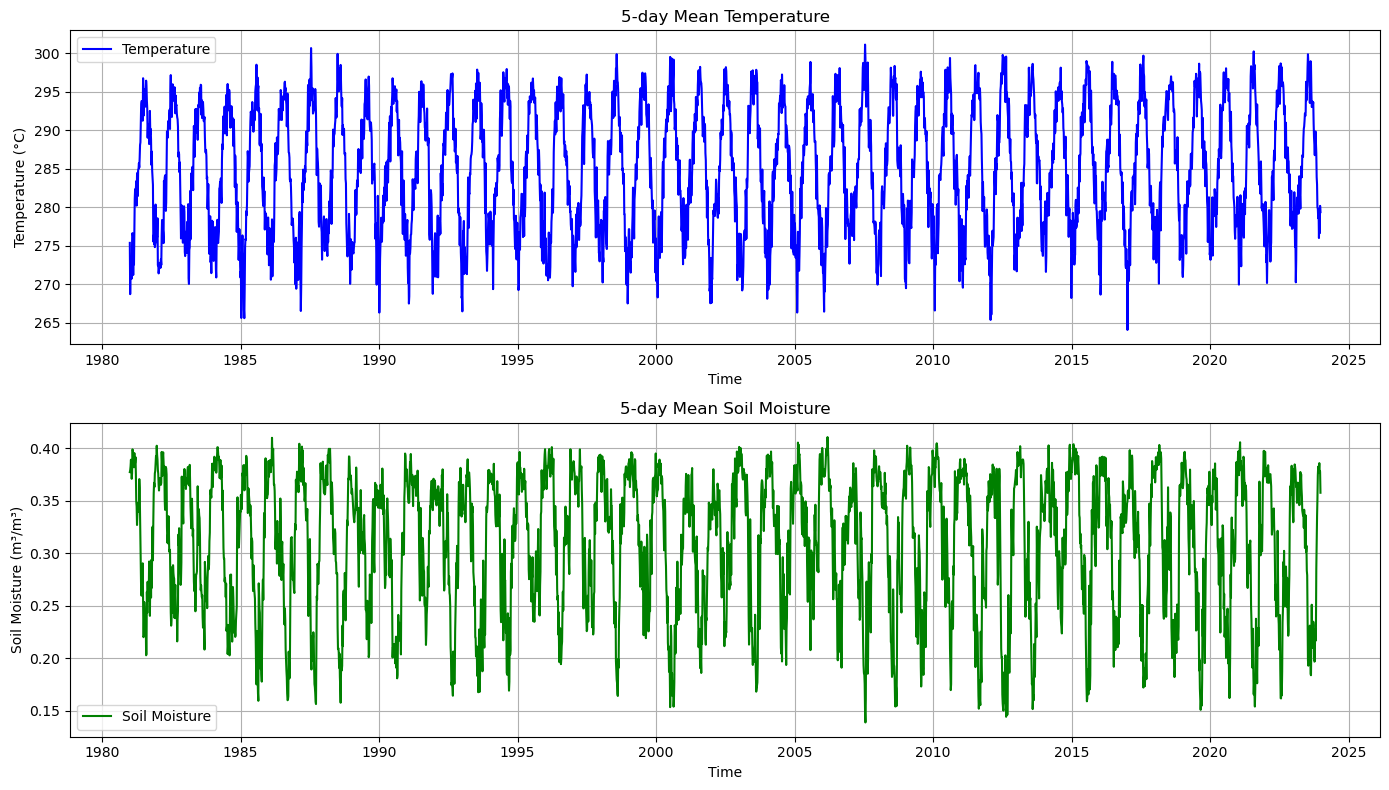

In [11]:
# Plotting the time series for 5-days
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_5daymean_avg.time, t2m_balkans_5daymean_avg, label='Temperature', color='blue')
plt.title('5-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_5daymean_avg.time, sm_balkans_5daymean_avg, label='Soil Moisture', color='green')
plt.title('5-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Detrend the data for 5-days
for j in range(time_cycle_5day):
    t2m_balkans_5daymean_avg[j::time_cycle_5day] = signal.detrend(t2m_balkans_5daymean_avg[j::time_cycle_5day], axis=0)
    sm_balkans_5daymean_avg[j::time_cycle_5day] = signal.detrend(sm_balkans_5daymean_avg[j::time_cycle_5day], axis=0)


#    NAO[j::time_cycle] = signal.detrend(NAO[j::time_cycle], axis=0)
#    AO[j::time_cycle] = signal.detrend(AO[j::time_cycle], axis=0)
#    MOI[j::time_cycle] = signal.detrend(MOI[j::time_cycle], axis=0)
#    RMM_MJO[j::time_cycle] = signal.detrend(RMM_MJO[j::time_cycle], axis=0)
#    PNA[j::time_cycle] = signal.detrend(PNA[j::time_cycle], axis=0)

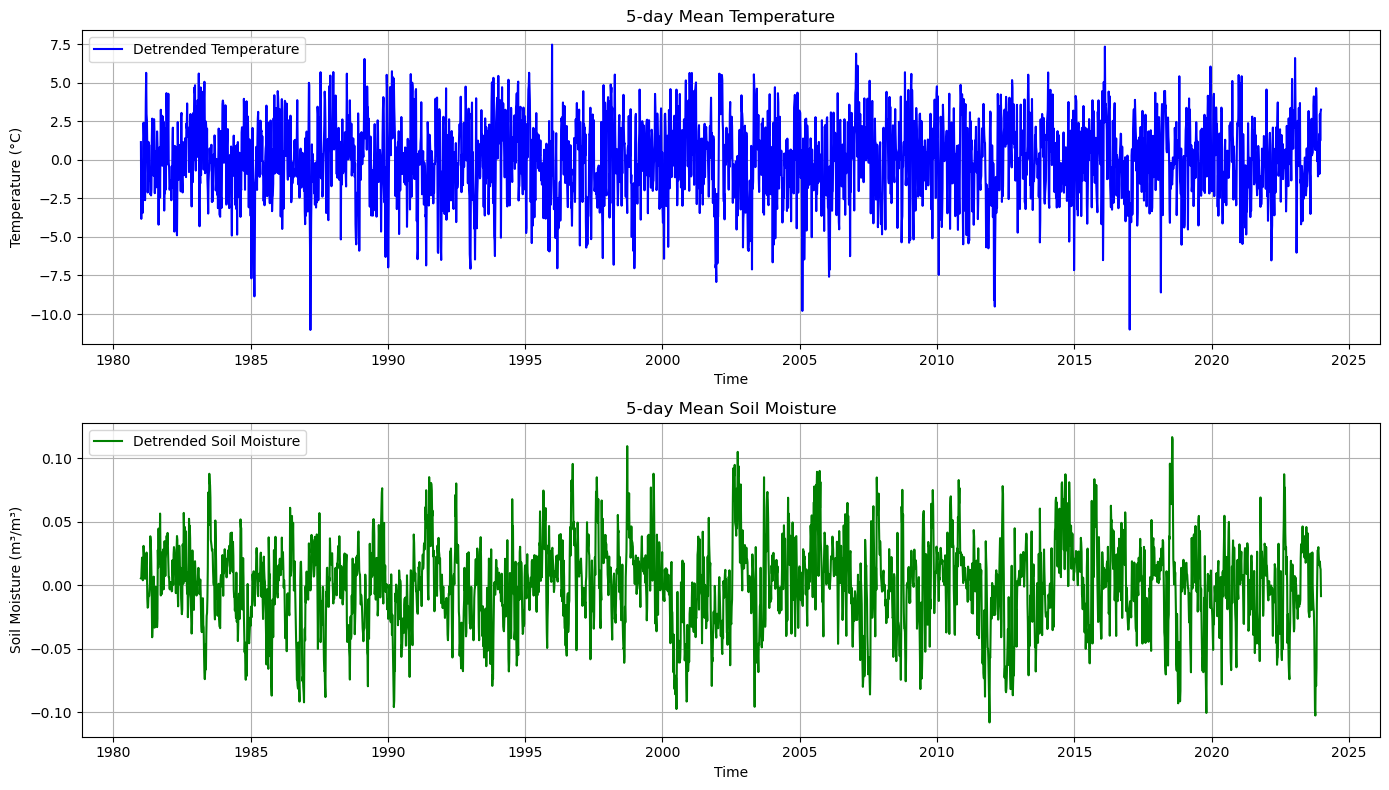

In [13]:
# Plotting the time series
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_5daymean_avg.time, t2m_balkans_5daymean_avg, label='Detrended Temperature', color='blue')
plt.title('5-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_5daymean_avg.time, sm_balkans_5daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('5-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Calculate anomalies for 5-days
for i in range(time_cycle_5day):
    t2m_balkans_5daymean_avg[i::time_cycle_5day] = (t2m_balkans_5daymean_avg[i::time_cycle_5day] - np.mean(t2m_balkans_5daymean_avg[:int(time_cycle_5day*n_years)][i::time_cycle_5day], axis=0))
    sm_balkans_5daymean_avg[i::time_cycle_5day] = (sm_balkans_5daymean_avg[i::time_cycle_5day] - np.mean(sm_balkans_5daymean_avg[:int(time_cycle_5day*n_years)][i::time_cycle_5day], axis=0))


#    NAO[i::time_cycle] = (NAO[i::time_cycle] - np.mean(NAO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    AO[i::time_cycle] = (AO[i::time_cycle] - np.mean(AO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    MOI[i::time_cycle] = (MOI[i::time_cycle] - np.mean(MOI[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    RMM_MJO[i::time_cycle] = (RMM_MJO[i::time_cycle] - np.mean(RMM_MJO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    PNA[i::time_cycle] = (PNA[i::time_cycle] - np.mean(PNA[:int(time_cycle*n_years)][i::time_cycle], axis=0))

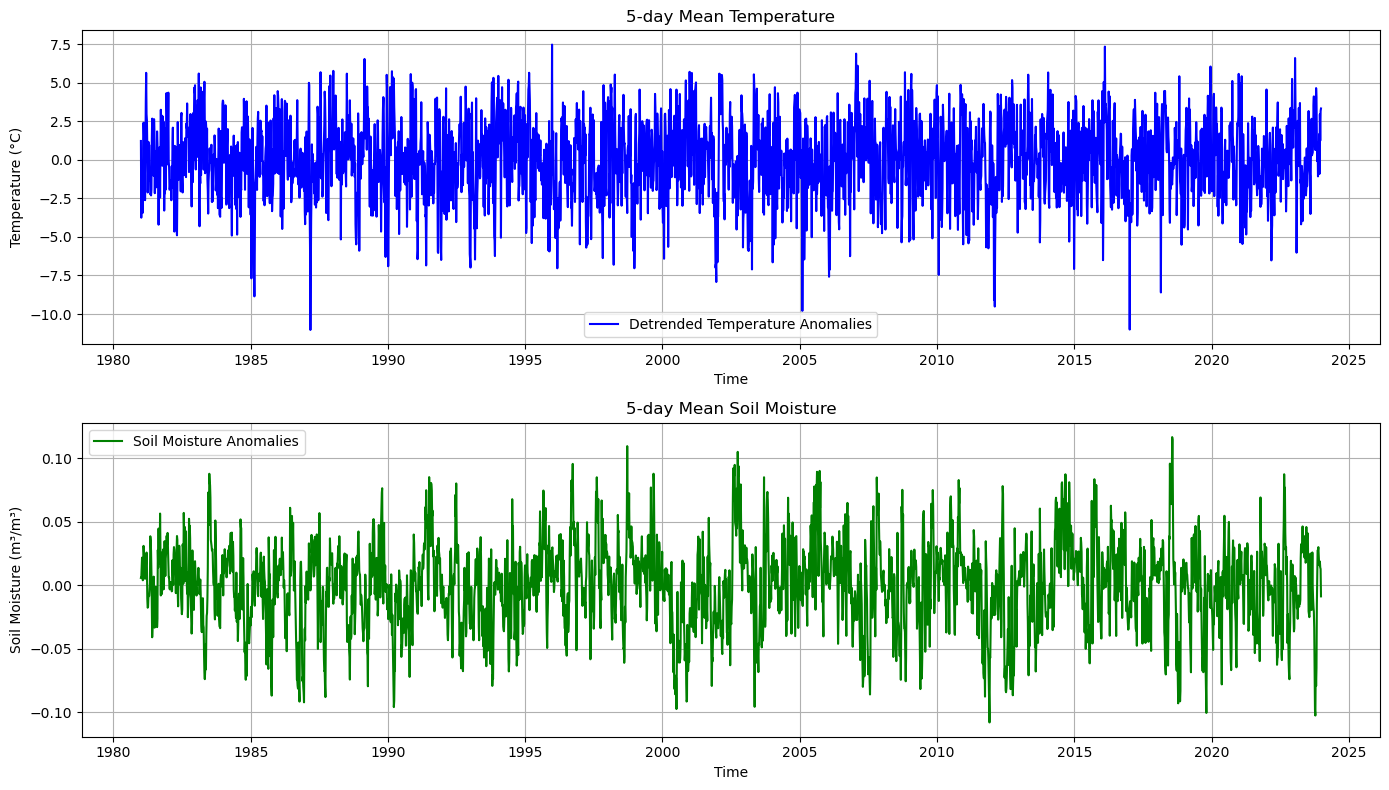

In [15]:
# Plotting the time series
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_5daymean_avg.time, t2m_balkans_5daymean_avg, label='Detrended Temperature Anomalies', color='blue')
plt.title('5-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_5daymean_avg.time, sm_balkans_5daymean_avg, label='Soil Moisture Anomalies', color='green')
plt.title('5-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3-Day window

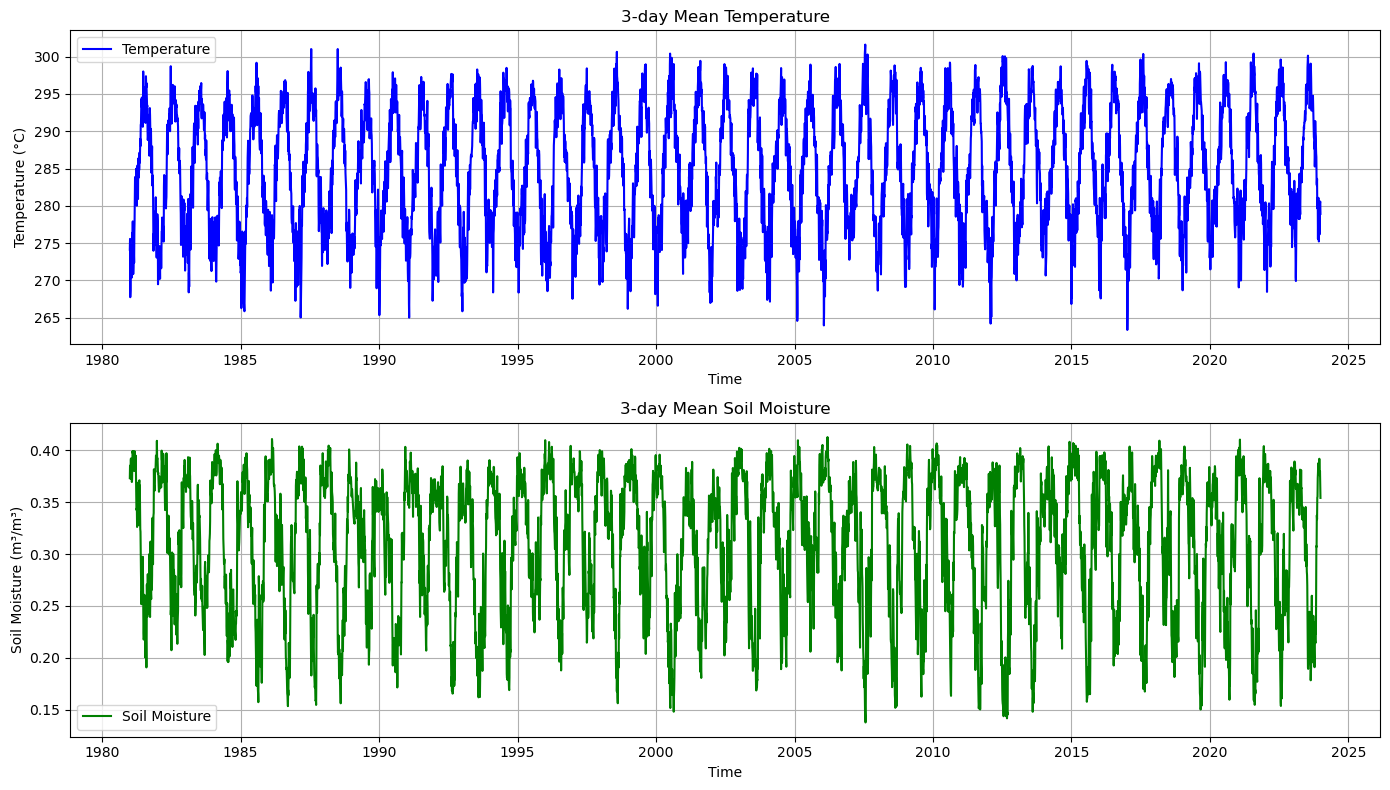

In [33]:
# Plotting the time series for 3-day data
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_3daymean_avg.time, t2m_balkans_3daymean_avg, label='Temperature', color='blue')
plt.title('3-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_3daymean_avg.time, sm_balkans_3daymean_avg, label='Soil Moisture', color='green')
plt.title('3-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Detrend the data for 3-days
for j in range(time_cycle_3day):
    t2m_balkans_3daymean_avg[j::time_cycle_3day] = signal.detrend(t2m_balkans_3daymean_avg[j::time_cycle_3day], axis=0)
    sm_balkans_3daymean_avg[j::time_cycle_3day] = signal.detrend(sm_balkans_3daymean_avg[j::time_cycle_3day], axis=0)


#    NAO[j::time_cycle] = signal.detrend(NAO[j::time_cycle], axis=0)
#    AO[j::time_cycle] = signal.detrend(AO[j::time_cycle], axis=0)
#    MOI[j::time_cycle] = signal.detrend(MOI[j::time_cycle], axis=0)
#    RMM_MJO[j::time_cycle] = signal.detrend(RMM_MJO[j::time_cycle], axis=0)
#    PNA[j::time_cycle] = signal.detrend(PNA[j::time_cycle], axis=0)

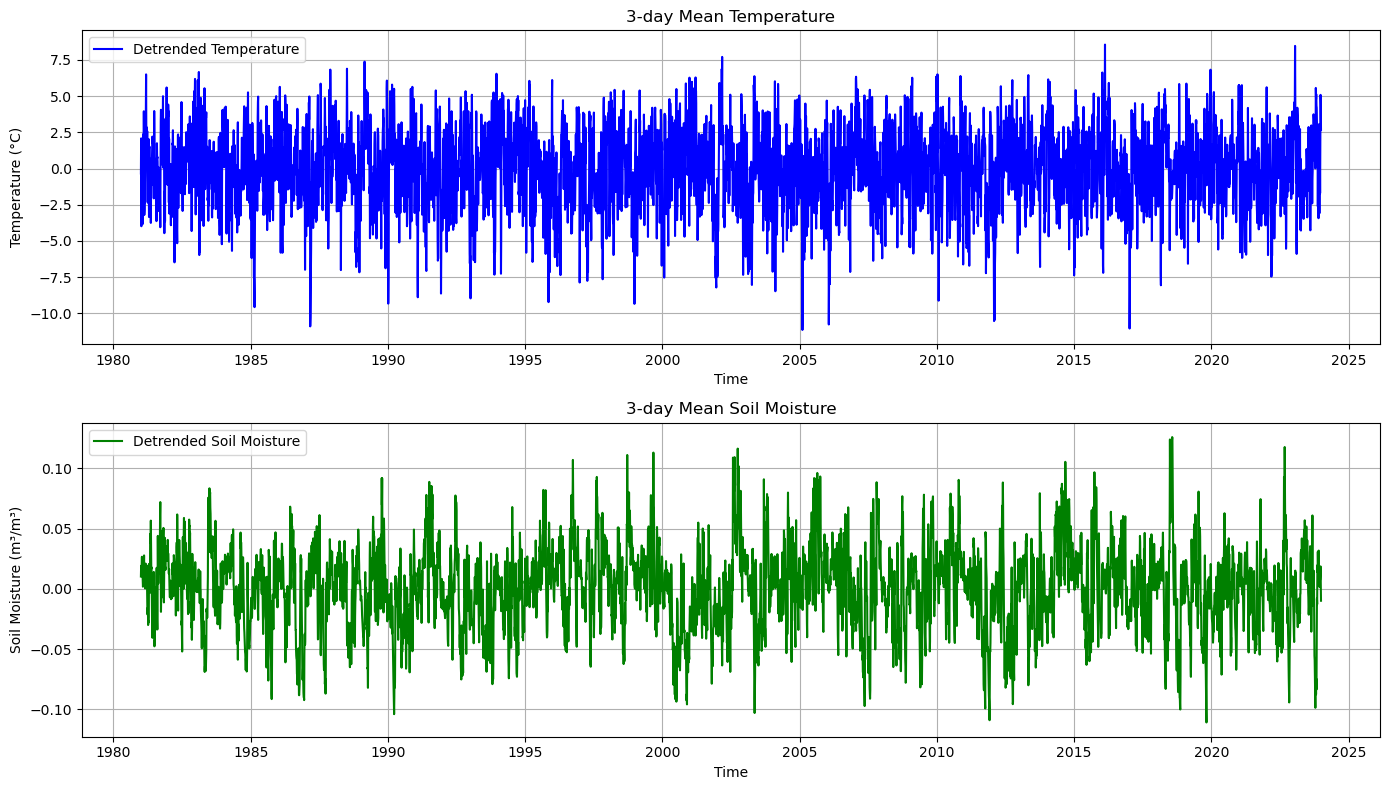

In [18]:
# Plotting the time series
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_3daymean_avg.time, t2m_balkans_3daymean_avg, label='Detrended Temperature', color='blue')
plt.title('3-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_3daymean_avg.time, sm_balkans_3daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('3-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Calculate anomalies for 3-days
for i in range(time_cycle_3day):
    t2m_balkans_3daymean_avg[i::time_cycle_3day] = (t2m_balkans_3daymean_avg[i::time_cycle_3day] - np.mean(t2m_balkans_3daymean_avg[:int(time_cycle_3day*n_years)][i::time_cycle_3day], axis=0))
    sm_balkans_3daymean_avg[i::time_cycle_3day] = (sm_balkans_3daymean_avg[i::time_cycle_3day] - np.mean(sm_balkans_3daymean_avg[:int(time_cycle_3day*n_years)][i::time_cycle_3day], axis=0))


#    NAO[i::time_cycle] = (NAO[i::time_cycle] - np.mean(NAO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    AO[i::time_cycle] = (AO[i::time_cycle] - np.mean(AO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    MOI[i::time_cycle] = (MOI[i::time_cycle] - np.mean(MOI[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    RMM_MJO[i::time_cycle] = (RMM_MJO[i::time_cycle] - np.mean(RMM_MJO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
#    PNA[i::time_cycle] = (PNA[i::time_cycle] - np.mean(PNA[:int(time_cycle*n_years)][i::time_cycle], axis=0))

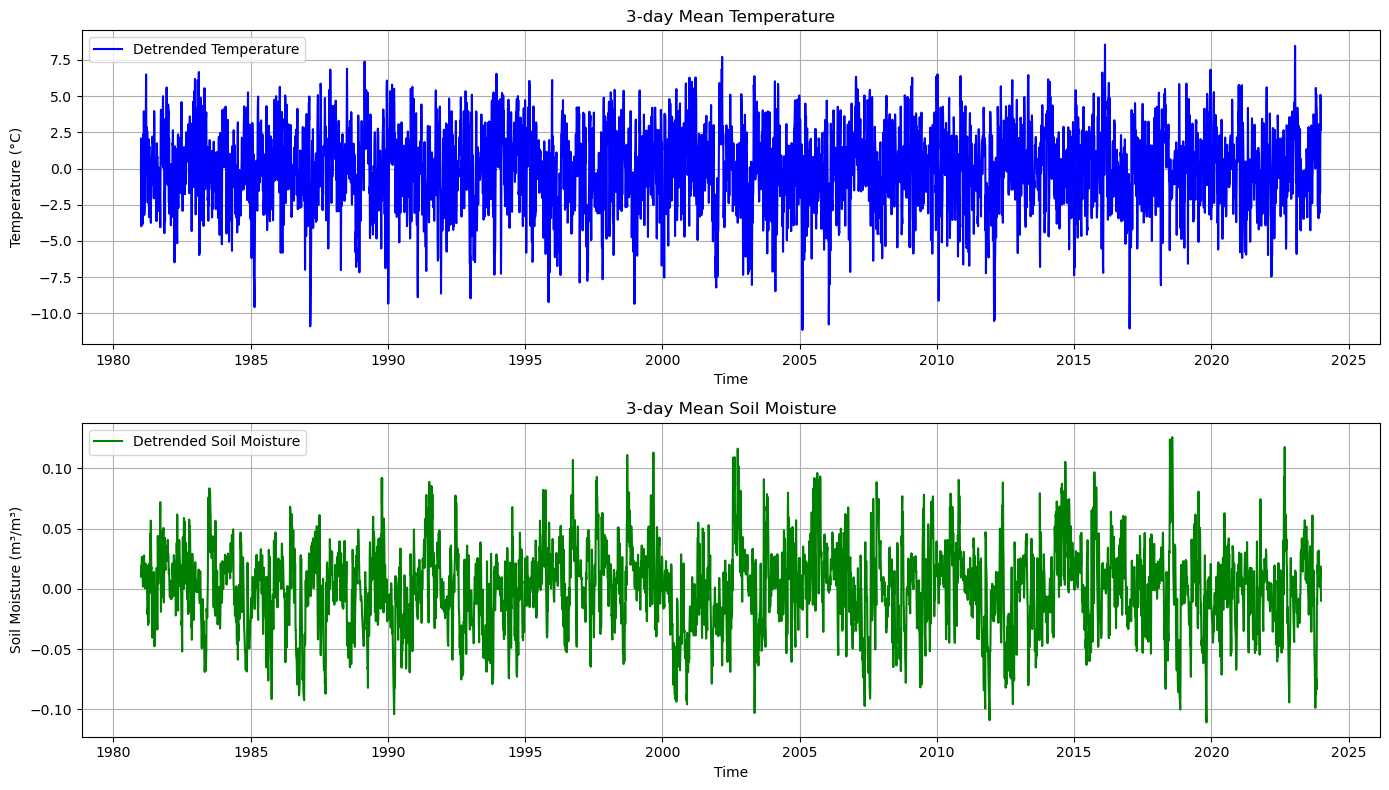

In [20]:
# Plotting the time series
plt.figure(figsize=(14, 8))

# Plot Temperature
plt.subplot(2, 1, 1)
plt.plot(t2m_balkans_3daymean_avg.time, t2m_balkans_3daymean_avg, label='Detrended Temperature', color='blue')
plt.title('3-day Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Plot Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(sm_balkans_3daymean_avg.time, sm_balkans_3daymean_avg, label='Detrended Soil Moisture', color='green')
plt.title('3-day Mean Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (m³/m³)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Export data to csv and .nc

In [34]:
### Extract 7-day data to csv
start_date = pd.to_datetime('1981-01-01')
date_range = pd.date_range(start=start_date, periods=len(t2m_balkans_7daymean_avg), freq='7D')

# Create a DataFrame
anomalies_7day_df = pd.DataFrame({
    'Date': date_range,
    'T2M_Anomaly': t2m_balkans_7daymean_avg,
    'SM_Anomaly': sm_balkans_7daymean_avg
})

# Save to CSV
anomalies_df.to_csv('anomalies_7day.csv', index=False)

In [ ]:
# Convert the DataFrame to an xarray Dataset
anomalies_ds = xr.Dataset(
    {
        'T2M_Anomaly': (('time'), anomalies_df['T2M_Anomaly'].values),
        'SM_Anomaly': (('time'), anomalies_df['SM_Anomaly'].values),
    },
    coords={
        'time': anomalies_7day_df['Date'].values
    }
)

# Export to NetCDF
anomalies_ds.to_netcdf('anomalies_7day.nc', format='NETCDF4')